## Vgg16 U-Net

The idea was to benefit from transfer learning and to use U-Net architecture in the same time. 
The results for Bipbip were about 70 % on Mais and 56% on Haricot.



In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [ ]:
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/My Drive/Development_Dataset/Test_Dev/AllTest.zip'

In [ ]:
# !ls /content/VOCDataset/Images

# **Preparing data for training**
1) Copying haricot and maize images from selected teams to a single folder. The structure should be 

```
___/
______ Challenge2            # Copy destionation dir
_________ Training
____________ Images
____________ Masks
____________ Splits
_________ Results
____________ submission.json
...
______ Development_dataset
_________ Training
____________ Bipbip
_______________ Haricot
__________________ Images
__________________ Masks
_______________ Mais
____________ Roseau [...]
_________ Test_Dev
____________ Bipbip
____________ Roseau [...]
```



In [ ]:
import shutil

# If you want to remove a team or a colture you have to delete all files of dest_train_img and dest_train_mask 

selected_teams = ['Bipbip'] # Selectable Bipbip, Pead, Roseau, Weedelec

original_dataset_dir = '/content/drive/My Drive/DANNDL/Development_Dataset'
orig_training_dir = os.path.join(original_dataset_dir, 'Training')

dest_dir = '/content/drive/My Drive/DANNDL/results2'
dest_training_dir = os.path.join(dest_dir, 'Training')
dest_training_dir

if not os.path.exists(dest_training_dir):
    os.makedirs(dest_training_dir)

dest_train_img = os.path.join(dest_training_dir, 'Images')
if not os.path.exists(dest_train_img):
    os.makedirs(dest_train_img)

dest_train_mask = os.path.join(dest_training_dir, 'Masks')
if not os.path.exists(dest_train_mask):
    os.makedirs(dest_train_mask)

colture_types = ['Haricot', 'Mais'] # Selectable Haricot, Mais

# Copying files from selected_teams into a single training folder, both Haricot and Maize
for team in selected_teams:
  curr_team_dir = os.path.join(orig_training_dir, team)
  for colture in colture_types:
    folder_types = ['Images', 'Masks']
    for folder in folder_types:
      current_dir = os.path.join(curr_team_dir,colture,folder)
      current_dest_dir = os.path.join(dest_training_dir, folder)
      src_files = os.listdir(current_dir)
      for file_name in src_files:
          full_file_name = os.path.join(current_dir, file_name)
          if os.path.isfile(full_file_name):
            if not os.path.exists(full_file_name):
              shutil.copy(full_file_name, current_dest_dir)


'/content/drive/My Drive/DANNDL/results2/Training'

2) Split training data into two subset training and validation set, creating the txt file in order to reuse function from Lattari's notebook

In [ ]:
training_all_files = os.listdir(dest_train_img)
np.random.shuffle(training_all_files)
validation_split = 0.1

train_files, val_files = np.split(training_all_files, [int(len(training_all_files)*(1-validation_split))])
dest_split_dir = os.path.join(dest_training_dir, 'Splits')
train_txt_file = os.path.join(dest_split_dir, 'train.txt')
val_txt_file = os.path.join(dest_split_dir, 'val.txt')

f = open(train_txt_file, "w")
for single_file in train_files:
  f.write(single_file[:-4] + '\n')
f.close()

f = open(val_txt_file, "w")
for single_file in val_files:
  f.write(single_file[:-4] + '\n')
f.close()

24

24

21

21

21

24

21

24

21

24

24

24

21

21

21

21

21

21

21

21

24

21

21

21

24

21

21

21

24

21

24

24

21

24

24

24

24

21

24

24

21

21

24

24

21

21

24

24

21

24

21

21

21

21

21

24

21

21

21

21

24

24

24

21

24

24

24

21

21

24

24

24

21

21

24

24

21

21

24

24

24

21

21

24

21

21

24

24

21

21

24

24

24

21

21

21

21

24

24

21

21

21

24

24

21

24

21

21

24

24

21

24

21

21

21

21

21

24

21

21

24

21

24

24

21

21

24

21

21

24

21

24

21

21

24

21

24

21

24

21

24

24

21

21

21

21

24

21

21

24

21

21

24

21

24

21

21

21

24

21

24

24

21

21

24

21

21

24

24

21

24

24

24

21

24

24

24

21

24

24

21

21

21

24

21

24

24

21

21

21

24

21

24

21

21

24

24

24

21

21

21

21

21

24

21

21

21

21

24

24

24

24

24

21

21

21

24

21

24

21

21

24

24

21

21

21

24

24

24

21

24

24

21

24

24

24

21

21

24

24

24

24

21

21

21

21

21

24

21

21

24

21

24

21

21

24

24

24

21

21

21

24

21

24

24

21

21

24

24

24

24

24

24

21

24

24

21

24

24

24

21

24

21

21

24

24

24

24

21

24

24

24

24

21

21

24

24

24

24

24

24

21

24

21

24

24

24

21

21

21

24

21

24

21

24

21

24

24

24

21

24

24

24

24

24

21

24

24

21

21

24

24

21

21

24

24

24

21

21

24

24

24

21

24

24

21

24

21

21

21

21

21

21

21

21

24

24

24

24

24

# Example: Image Segmentation
## Build segmentation

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image

def read_rgb_mask(img_path, out_shape):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    if (out_shape is not None):
      mask_img = mask_img.resize(out_shape)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0 #background
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1 #crop
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2 #weed

    return new_mask_arr

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256], backward_step = 20):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.backward_step = backward_step

  def __len__(self):
    return len(self.subset_filenames)

  def __iter__(self):
    """Create a generator that iterate over the Sequence."""
    for item in (self[i] for i in range(len(self))):
      # dir(item)
      for j in range(len(item[0])):
        yield item[0][j], item[1][j]

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))

    # Resize image and mask
    # img = img.resize(self.out_shape)
    
    img_arr = np.array(img)
    mask_arr = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'), None)
    # img_arr.shape()
    # mask_arr.shape()

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)
    
    img_arr = img_arr / 255

    batch_img = []
    batch_mask = []

    curr_x = 0
    curr_y = 0
    source_width = img_arr.shape[1]
    source_height = img_arr.shape[0]
    out_width = self.out_shape[1]
    out_height = self.out_shape[0]
    # print(img_arr.shape)

    while (curr_y < source_height):
      curr_y = curr_y - self.backward_step
      if (curr_y < 0):
        curr_y = 0
      if (curr_y + out_height > source_height):
        curr_y = source_height - out_height
      curr_x = 0
      while (curr_x < source_width):
        curr_x = curr_x - self.backward_step
        if (curr_x < 0):
          curr_x = 0
        if (curr_x + out_width > source_width):
          curr_x = source_width - out_width
        curr_img_arr = img_arr[curr_y : curr_y+out_height, curr_x : curr_x+out_width]
        curr_out_mask = out_mask[curr_y : curr_y+out_height, curr_x : curr_x+out_width]
        # print(curr_img_arr.shape)
        batch_img.append(curr_img_arr)
        batch_mask.append(np.float32(curr_out_mask))
        curr_x = curr_x + out_width
        # yield curr_img_arr, curr_out_mask
      curr_y = curr_y + out_height

    return batch_img, batch_mask

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

# Bipbip original size 2048 x 1536 [4:3]
# Pead original size 3280 x 2464 [4:3]
# Roseau original size 1227 x 820 [3:2]
# Bipbip original size 5184 x 3456 [3:2]
img_h = 480
img_w = 480
num_classes = 3

backstep = 20


dataset = CustomDataset(dest_training_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None, out_shape=[img_w,img_h], backward_step = backstep)
dataset_valid = CustomDataset(dest_training_dir, 'validation', 
                              preprocessing_function=None, out_shape=[img_w,img_h], backward_step = backstep)


In [ ]:
batch_size = 10

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(batch_size)

valid_dataset = valid_dataset.repeat()

In [ ]:
# !ls /content/VOCDataset

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0.]


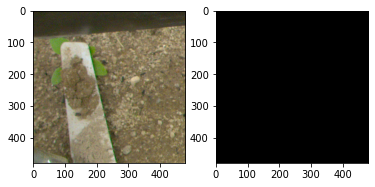

In [ ]:
fig, ax = plt.subplots(1, 2)
augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize
augmented_img = augmented_img * 255
target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
conv_colors = [[216, 124, 18], [255, 255, 255], [216, 67, 82]]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = conv_colors[i]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# STRANGE SOURCE IMAGES ARE DUE TO VGG PREPROCESS_INPUT FUNCTION

In [ ]:
inputs = Input((img_h, img_w,3))

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
vgg.summary()

vggLayers=[]

freeze_until = 11
finetuning = True
if finetuning:
  for layer in vgg.layers[:freeze_until]:
    vggLayers.append(layer)
    layer.trainable = False
  for layer in vgg.layers[freeze_until:]:
    vggLayers.append(layer)
else:
  for layer in vgg.layers:
    vggLayers.append(layer)
    layer.trainable = False

# vggLayers is composed of 19 layers, conv layers are in these indexes in vggLayers list : 1,2,4,5,7,8,9,11,12,13,15,16,17
# we can thus place shortcuts here : 17,13,9,5,2


## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def add_conv_block(input, filters, pool=True, nbConv=2):
    x=Conv2D(filters=filters,kernel_size=(3, 3), strides=(1, 1), padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)

    for i in range(1,nbConv):
      x=Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
      x=BatchNormalization()(x)
      x=Activation("relu")(x)

    if pool == True:
        x = MaxPool2D((2, 2))(x)

    return x

def build(num_classes):
    """ Bridge """
    b1 = add_conv_block(vggLayers[-1].output, 512, pool=False)

    # vgg out : 12x16x512 ; we can put shorcuts here (idx of the vggLayers list) : 17,13,9,5,2
    """ Decoder """
    u1 = UpSampling2D(2, interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, vggLayers[17].output])
    x1 = add_conv_block(c1, 512, pool=False, nbConv=3)

    u2 = UpSampling2D(2, interpolation="bilinear")(x1)
    c2 = Concatenate()([u2, vggLayers[13].output])
    x2 = add_conv_block(c2, 256, pool=False, nbConv=3)

    u3 = UpSampling2D(2, interpolation="bilinear")(x2)
    c3 = Concatenate()([u3, vggLayers[9].output])
    x3 = add_conv_block(c3, 128, pool=False, nbConv=3)

    u4 = UpSampling2D (2, interpolation="bilinear")(x3)
    c4 = Concatenate()([u4, vggLayers[5].output])
    x4 = add_conv_block(c4, 64, pool=False)

    u5 = UpSampling2D (2, interpolation="bilinear")(x4)
    c5 = Concatenate()([u5, vggLayers[2].output])
    x5 = add_conv_block(c5, 16, pool=False)

    """ Output layer """
    output = Conv2D(filters=num_classes, kernel_size=(1, 1),strides=(1, 1), padding="same", activation="softmax")(x5)

  
    return Model(inputs=inputs, outputs=output)



In [ ]:
model = build(num_classes)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 480, 480, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 480, 480, 32) 128         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 480, 480, 32) 0           batch_normalization_42[0][0]     
_______________________________________________________________________________________

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
# ckpt_dir = os.path.join(exp_dir, 'ckpts')
# if not os.path.exists(ckpt_dir):
#     os.makedirs(ckpt_dir)

# ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
#                                                    save_weights_only=True)  # False to save the model directly
# callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=4, mode="max")
    callbacks.append(es_callback)

reduce_on_plateau = True
if reduce_on_plateau:
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                  patience=3, min_lr=0.001)
  callbacks.append(reduce_lr)

model.fit(x=train_dataset,
          epochs=70,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/70


ResourceExhaustedError: ignored

## Test model

## Compute prediction

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

class TestDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """
  # orig_shape = (width, height)
  def __init__(self, orig_dataset_dir, teams, crops, preprocessing_function=None,orig_shape=[256,256]):
    total = 0
    for team in teams:
      for crop in crops:
        curr_dir = os.path.join(orig_dataset_dir, 'Test_Dev', team, crop, 'Images')
        total += len(os.listdir(curr_dir))

    print(orig_dataset_dir)
    print(total)
    self.length = total
    self.orig_dataset_dir = orig_dataset_dir
    self.teams = teams
    self.crops = crops
    self.preprocessing_function = preprocessing_function
    self.orig_shape = orig_shape
    # self.out_shape = out_shape

  def __len__(self):
    return self.length

  def __getInfo__(self,index):
    curr_index = 0
    for team in self.teams:
      for crop in self.crops:
        curr_dir_files = os.path.join(self.orig_dataset_dir, 'Test_Dev', team, crop, 'Images')
        # print(curr_dir_files)
        for curr_file in os.listdir(curr_dir_files):
          if (curr_index == index):
            curr_team = team
            curr_crop = crop
            curr_filename = curr_file
          curr_index += 1

    if (curr_team == 'Bipbip'):
      curr_out_shape = [1536,2048]
    elif (curr_team == 'Roseau'):
      curr_out_shape = [820,1227]
    elif (curr_team == 'Pead'):
      curr_out_shape = [2464,3280]
    elif (curr_team == 'Weedelec'):
      curr_out_shape = [3456,5184]

    return curr_filename, curr_team, curr_crop, curr_out_shape

  def __getitem__(self, index):
    # Read Image
    # print(self.orig_dataset_dir)
    curr_index = 0
    for team in self.teams:
      for crop in self.crops:
        curr_dir_files = os.path.join(self.orig_dataset_dir, 'Test_Dev', team, crop, 'Images')
        # print(curr_dir_files)
        for curr_file in os.listdir(curr_dir_files):
          if (curr_index == index):
            curr_team = team
            curr_crop = crop
            curr_filename = curr_file
          curr_index += 1

    # print(os.path.join(self.orig_dataset_dir, 'Test_Dev', curr_team, curr_crop, 'Images', curr_filename))
    # curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.orig_dataset_dir, 'Test_Dev', curr_team, curr_crop, 'Images', curr_filename))

    # Resize image and mask
    img = img.resize(self.orig_shape)
    
    img_arr = np.array(img)
    # Shape as (height, width, depth = 1)
    target_zero = np.zeros((self.orig_shape[1], self.orig_shape[0], 1))
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)
    
    img_arr = img_arr / 255

    return img_arr, target_zero

  

In [ ]:
orig_w = img_w       # 2048
orig_h = img_h       # 1536
dataset_test = TestDataset(orig_dataset_dir=original_dataset_dir, teams=['Bipbip','Pead','Roseau','Weedelec'], crops=['Haricot','Mais'], orig_shape=[orig_w,orig_h])

test_dataset = tf.data.Dataset.from_generator(lambda: dataset_test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([orig_h, orig_w, 3], [orig_h, orig_w, 1]))
test_dataset = test_dataset.batch(1)

# test_dataset = test_dataset.repeat()

/content/drive/My Drive/DANNDL/Development_Dataset
120


In [ ]:
from datetime import datetime
import json

curr_index = 0
submission_dict = {}

# dir(dataset_test)

for image,target in test_dataset:
  print(curr_index)
  current_info = dataset_test.__getInfo__(curr_index)
  image = image[0]
  out_sigmoid = model.predict(x=tf.expand_dims(image, 0))
  out_resized = tf.image.resize(out_sigmoid, current_info[3], method='nearest')
  predicted_class = tf.argmax(out_resized, -1)
  predicted_class = predicted_class[0, ...]
  # predicted_class
  # predict_resized = tf.image.resize(predicted_class, current_info[3], method='nearest')

  # print(predicted_class.shape)

  img_name = current_info[0][:-4]
  submission_dict[img_name] = {}
  submission_dict[img_name]['shape'] = [predicted_class.shape[0],predicted_class.shape[1]]
  submission_dict[img_name]['team'] = current_info[1]
  submission_dict[img_name]['crop'] = current_info[2]
  submission_dict[img_name]['segmentation'] = {}

  # RLE encoding
  # crop
  rle_encoded_crop = rle_encode(np.array(predicted_class == 1))
  # weed
  rle_encoded_weed = rle_encode(np.array(predicted_class == 2))

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

  curr_index += 1

now = datetime.now().strftime('%b%d_%H-%M-%S')
with open(os.path.join(dest_dir,'Results','submission.json'), 'w') as f:
  json.dump(submission_dict, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


(1, 384, 512, 3)

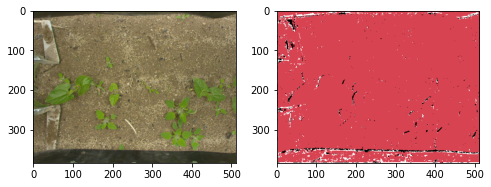

In [ ]:
iterator = iter(test_dataset)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
image = image * 255

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
# target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([image.shape[0], image.shape[1], 3])

# target_img[np.where(target == 0)] = [0, 0, 0]
# for i in range(1, 21):
#   target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  prediction_img[np.where(predicted_class == i)] = conv_colors[i]

ax[0].imshow(np.uint8(image))
# ax[1].imshow(np.uint8(target_img))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)